In [1]:
# Import the libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt  # for 畫圖用
import pandas as pd# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,GRU, Input, ConvLSTM2D, Bidirectional,BatchNormalization
from tensorflow.keras import Input
#from tensorflow.keras.layers.normalization import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
import math
import json
from IPython.core.pylabtools import figsize
figsize(15, 7) 
Zabbix_Data = pd.read_csv('./dataset/TJNEWM_HEAP_MEM_USED_85%MAX_2021_Jan&Feb.csv', sep=',', 
                 parse_dates={'dt' : ['Date']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

#Zabbix_Data = pd.read_csv('./dataset/TJNEWM_HEAP_MEM_USED_85%MAX_2021_Jan&Feb.csv')
Zabbix_Data = Zabbix_Data.reindex(index=Zabbix_Data.index[::-1])
Zabbix_Data




,Commit,Used,%used
dt,,,
2021-01-19 15:46:00,1611042390,1743335128,108.211624
2021-01-19 15:47:00,1611042450,1855382384,115.166573
2021-01-19 15:48:00,1611042510,1399247256,86.853528
2021-01-19 15:49:00,1611042570,2137643960,132.686994
2021-01-19 15:50:00,1611042630,1478162688,91.751929
...,...,...,...
2021-02-23 15:51:00,1614066690,1157554888,71.716670
2021-02-23 15:52:00,1614066750,1394843936,86.417983
2021-02-23 15:53:00,1614066810,1267484624,78.527395


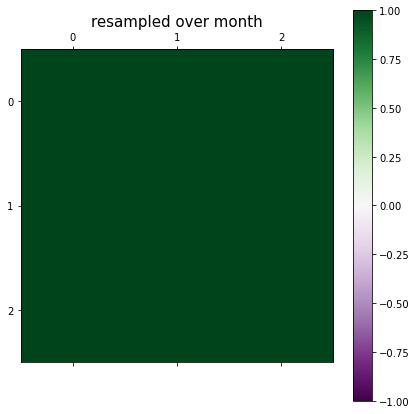

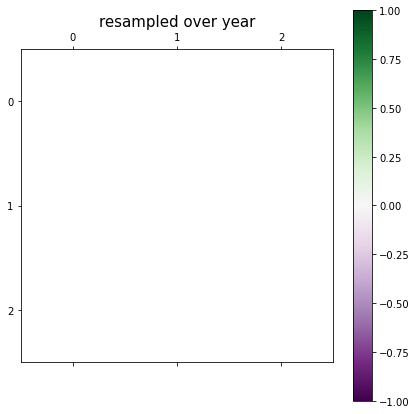

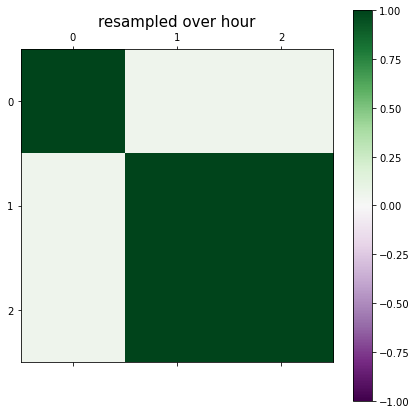

In [2]:
plt.matshow(Zabbix_Data.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(Zabbix_Data.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()
plt.matshow(Zabbix_Data.resample('h').sum().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over hour', size=15)
plt.colorbar()
plt.show()

In [3]:
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized# Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

1 Physical GPUs, 1 Logical GPUs


In [4]:
for j in range(3):
       print(Zabbix_Data.iloc[:, j].unique())

[1611042390 1611042450 1611042510 ... 1614066810 1614066870 1614066930]
[1743335128 1855382384 1399247256 ... 1267484624 1175337280 1245582936]
[108.2116237 115.1665733  86.8535279 ...  78.5273953  72.8183759
  77.1704638]


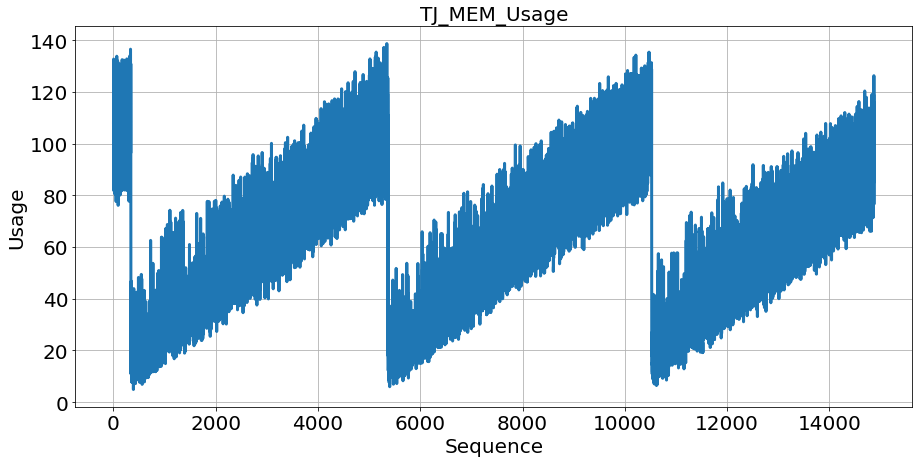

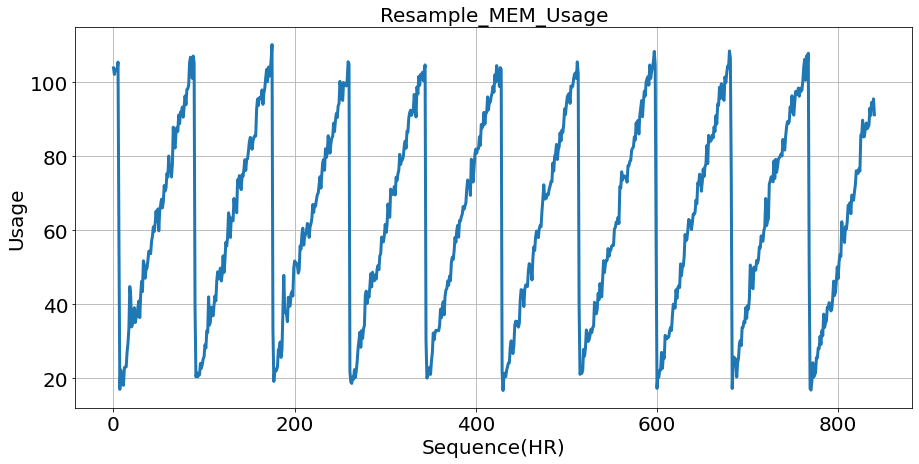

In [8]:
plt.plot(Zabbix_Data['%used'][:14880].values,linewidth=3,label='usage_rate')
plt.title('TJ_MEM_Usage',fontsize=20)
plt.ylabel('Usage',fontsize=20)
plt.xlabel('Sequence',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
#plt.legend(fontsize='large',loc='right')
plt.show()

values = Zabbix_Data['%used'].resample('H').mean().values
plt.plot(values,linewidth=3,label='usage_rate')
plt.title('Resample_MEM_Usage',fontsize=20)
plt.ylabel('Usage',fontsize=20)
plt.xlabel('Sequence(HR)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
#plt.legend(fontsize='large',loc='right')
plt.show()

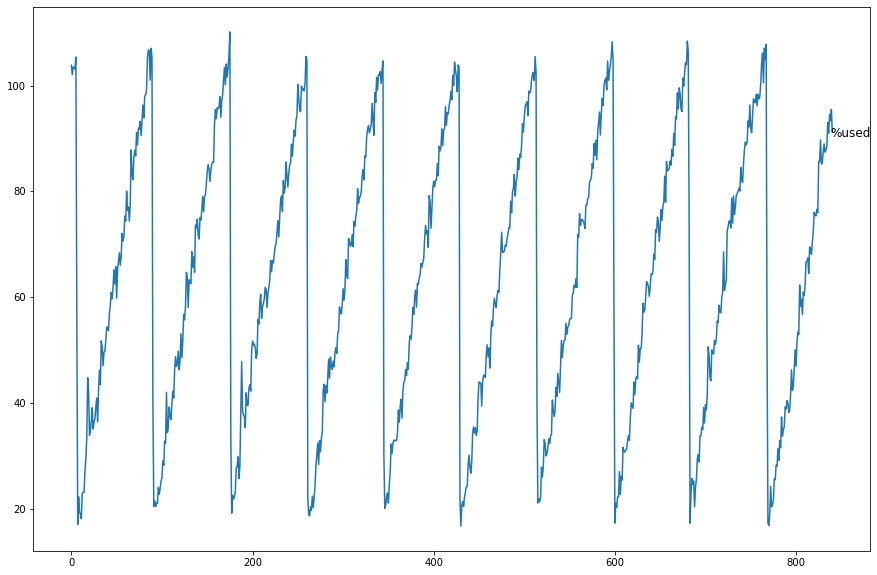

In [9]:
# Below I compare the mean of different features resampled over day. 
# specify columns to plot
df = Zabbix_Data
cols = [2]
i = 1
groups=cols
values = df.resample('H').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

In [15]:
#Usage_data = Zabbix_Data['%used'].resample('H').mean()
Usage_data = Zabbix_Data['%used']

Data_arr = Usage_data.values.reshape(-1,1)
Data_arr.shape

(50408, 1)

In [16]:
training_count = int(Data_arr.shape[0]*0.8)

training_set = Data_arr[:training_count,:]
testing_set = Data_arr[training_count:]

In [17]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler,RobustScaler


#MinMaxScaler


#sc_train = MinMaxScaler(feature_range=(0,1))
#dataset_train_scaled = sc_train.fit_transform(training_set)

#sc_test = MinMaxScaler(feature_range=(0,1))
#dataset_test_scaled = sc_test.fit_transform(testing_set)


#RobustScaler

sc_train = RobustScaler()
dataset_train_scaled = sc_train.fit_transform(training_set)


sc_test = RobustScaler()
dataset_test_scaled = sc_test.fit_transform(testing_set)


In [18]:
def gen_dataset(data,x_window_size,y_window_size):
    X_train = []   #預測點的前 60 天的資料
    y_train = []   #預測點
    for i in range(x_window_size, data.shape[0]-y_window_size,y_window_size):
        X_train.append(data[i-x_window_size:i, :])
        y_train.append(data[i:i+y_window_size, 0:1 ])

    X_train, y_train = np.array(X_train), np.array(y_train)  # 轉成numpy array的格式，以利輸入 RNN
    
    X_train = np.reshape(X_train, (X_train.shape[0], x_window_size,data.shape[1] ))
    y_train = np.reshape(y_train,(y_train.shape[0],y_train.shape[1]))
    
    return X_train,y_train
  
    
    
X_train,y_train = gen_dataset(dataset_train_scaled,1,1)
X_test,y_test = gen_dataset(dataset_test_scaled,1,1)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40324, 1, 1)
(40324, 1)
(10080, 1, 1)
(10080, 1)


In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

rp = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.01, 
    patience=5, 
    verbose=1, 
    mode='auto', 
    min_delta=0.01, 
    cooldown=0, 
    min_lr=0
)
filepath=r".\model\NXP_model\NXP_best_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,
mode='max')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 64)             12864     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                9408      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 22,305
Trainable params: 22,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1009/1009 [==============================] - 15s 6ms/step - loss: 0.3662 - val_loss: 0.3070
Epoch 2/50
1009/1009 [==============================] - 5s 5ms/step - loss: 0.2856 - val_loss: 0.3131
Epoch 3/50
1009/1009 [==============================] - 5s 5ms/step - loss: 0.2834 - val_loss: 0.3169
Epoch 4/50
1009/1009 [==============================] - 5s 5ms/step - loss:

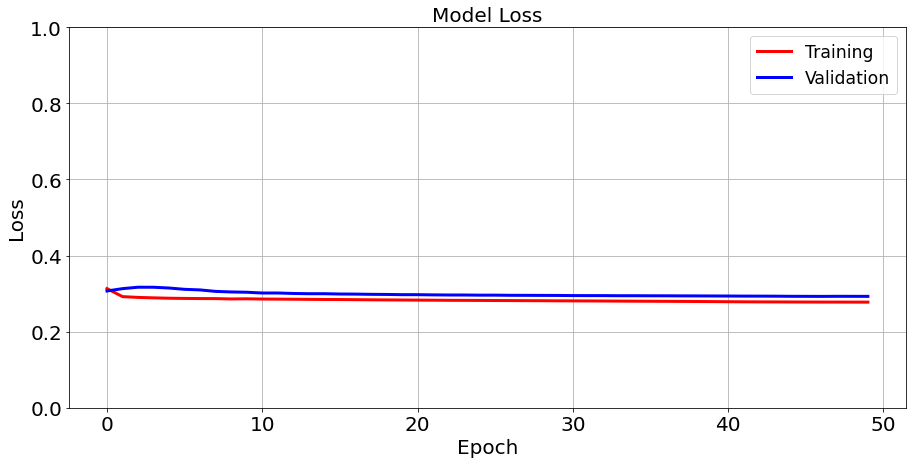

In [20]:

from attention import Attention


model = Sequential()
model.add(GRU(64,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True,unroll=False))
model.add(GRU(32, return_sequences=False,unroll=False))
#model.add(Attention(32))

model.add(Dense(y_test.shape[1]))
#model.add(Activation('linear'))
optz_fun = Adam(learning_rate=0.001)

model.compile(loss='mae',optimizer=optz_fun)
model.summary()
EPOCH = 50
BATCH = 32
history = model.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH,validation_split=0.2,callbacks=[],shuffle=False,verbose=1)

plt.plot( history.history['loss'], 'r', label='Training',linewidth=3)
plt.plot( history.history['val_loss'], 'b', label='Validation',linewidth=3)
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0,1)
plt.grid()
plt.legend(fontsize='xx-large')
plt.show()






In [21]:
model = Sequential()
model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]), return_sequences=True,unroll=False))
model.add(LSTM(32, return_sequences=False,unroll=False))
#model.add(Attention(32))

model.add(Dense(y_test.shape[1]))
#model.add(Activation('linear'))
optz_fun = Adam(learning_rate=0.001)

model.compile(loss='mae',optimizer=optz_fun)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


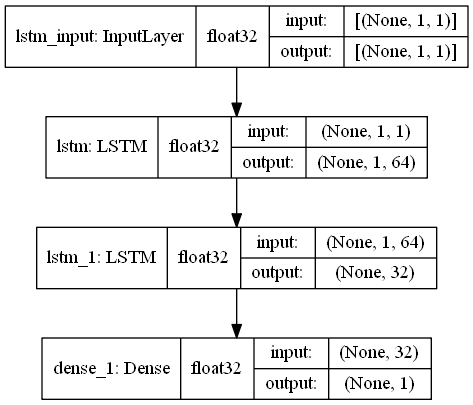

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

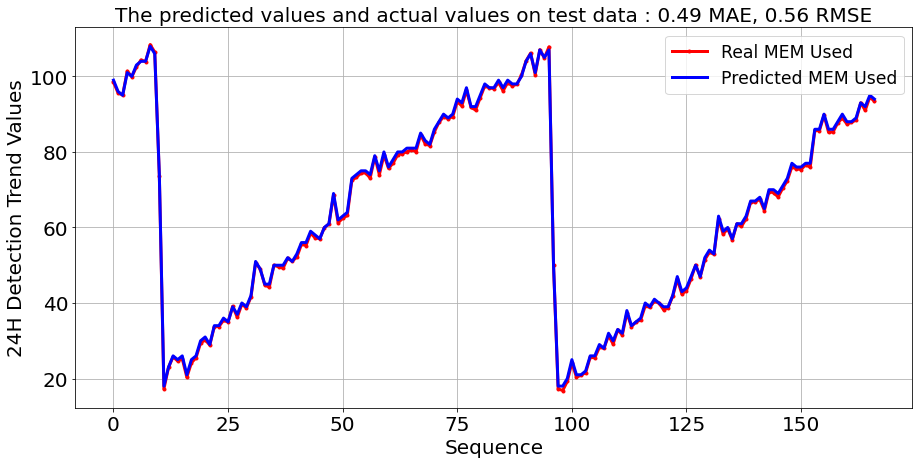

Result:
Test Score: 0.49 MAE
Test Score: 0.56 RMSE


In [29]:
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error
from  datetime import datetime

predicted_traffic = model.predict(X_test)
predicted_traffic = sc_test.inverse_transform(predicted_traffic) 

predicted_traffic = predicted_traffic.astype('int64')
predicted_traffic = predicted_traffic.flatten()


MAEScore = mean_absolute_error(testing_set[:-2,:],predicted_traffic)
RMSEScore = math.sqrt(mean_squared_error(testing_set[:-2,:],predicted_traffic))


plt.plot(testing_set[:-2,:],color = 'red',marker='.', label = 'Real MEM Used',linewidth=3)
plt.plot(predicted_traffic[:],color = 'blue', label = 'Predicted MEM Used',linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize='xx-large')
plt.xlabel('Sequence',fontsize=20)
plt.ylabel('24H Detection Trend Values',fontsize=20)
plt.title('The predicted values and actual values on test data : %.2f MAE, %.2f RMSE'%(MAEScore,RMSEScore),fontsize=20)
plt.show()



now_time = datetime.now()     #獲取當前時間
now_time = now_time.strftime('%Y%m%d_%H%M%S')   #列印需要的資訊,依次是年月日,時分秒,注意字母大小寫
print ("Result:")


print('Test Score: %.2f MAE' % (MAEScore))
print('Test Score: %.2f RMSE' % (RMSEScore))

In [ ]:
import time
proccess_time_list = []
for i in range(8,8*1700,8):
    start = time.process_time()
    predicted_traffic = model.predict(X_test[:i])
    end = time.process_time()  
    proccess_time_list.append(end-start) 
plt.plot(proccess_time_list)

In [ ]:
predicted_traffic = model.predict(X_test)


predicted_traffic = sc_test.inverse_transform(predicted_traffic) 
#predicted_traffic = predicted_traffic.astype('int64')
predicted_traffic = predicted_traffic



show_data_count = 0

plt.plot(dataset_test[abs(dataset_test.shape[0]-predicted_traffic.shape[0]):,:],color = 'red', label = 'Real CPU Used')
plt.plot(predicted_traffic[:,:],color = 'blue', label = 'Predicted CPU Used')

#plt.axhline(y=60, xmin=0, xmax=predicted_traffic.shape[0],label = 'upper')
#plt.axhline(y=30, xmin=0, xmax=predicted_traffic.shape[0],label = 'low')
plt.xlabel('Sequence')
plt.ylabel('24H Detection Trend Values')
plt.title('the predicted values and actual values (for the test data)')
plt.legend()

from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error
from  datetime import datetime

now_time = datetime.now()     #獲取當前時間
now_time = now_time.strftime('%Y%m%d_%H%M%S')   #列印需要的資訊,依次是年月日,時分秒,注意字母大小寫
print ("Result:")

print("-------------------------------")
#MAEScore_array = np.mean(abs(testing_set[61:]-predicted_traffic))
MAEScore = mean_absolute_error(dataset_test[abs(dataset_test.shape[0]-predicted_traffic.shape[0]):,:],predicted_traffic)
RMSEScore = math.sqrt(mean_squared_error(dataset_test[abs(dataset_test.shape[0]-predicted_traffic.shape[0]):,:],predicted_traffic))
#print(MAEScore_array)

print('Test Score: %.2f MAE' % (MAEScore))
print('Test Score: %.2f RMSE' % (RMSEScore))


In [ ]:
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error
from  datetime import datetime

now_time = datetime.now()     #獲取當前時間
now_time = now_time.strftime('%Y%m%d_%H%M%S')   #列印需要的資訊,依次是年月日,時分秒,注意字母大小寫
print ("Result:")

print("-------------------------------")
#MAEScore_array = np.mean(abs(testing_set[61:]-predicted_traffic))
MAEScore = mean_absolute_error(dataset_test[abs(dataset_test.shape[0]-predicted_traffic.shape[0]):,:],predicted_traffic)
RMSEScore = math.sqrt(mean_squared_error(dataset_test[abs(dataset_test.shape[0]-predicted_traffic.shape[0]):,:],predicted_traffic))
#print(MAEScore_array)

print('Test Score: %.2f MAE' % (MAEScore))
print('Test Score: %.2f RMSE' % (RMSEScore))

"""
anomaly_index = dataset_test.loc[dataset_test['value'] >= 60, ['timestamp', 'value']].index
anomaly_value = dataset_test.loc[dataset_test['value'] >= 60, ['value']].values
anomaly_MAEScore = mean_absolute_error(predicted_traffic[anomaly_index],anomaly_value)
anomaly_RMSEScore = math.sqrt(mean_squared_error(predicted_traffic[anomaly_index],anomaly_value))


print('Anomaly_Test Score: %.2f MAE' % (anomaly_MAEScore))
print('Anomaly_Test Score: %.2f RMSE' % (anomaly_RMSEScore))

print("-------------------------------")
"""
"""
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='./model_plot/LSTM_AWS_model.png',show_shapes=True)
"""
tf.saved_model.save(model, "Zabbix")
#model.save("./model/AWS_model/AWS_model.h5")

In [ ]:
diff_list = []
for i in range(predicted_traffic.shape[0]):
    #plt.plot(predicted_traffic[i:i+1][0]-predicted_traffic[i-1][0])
    #print(predicted_traffic[i]-predicted_traffic[i-1])
    
    diff_list.append(abs(predicted_traffic[i]-predicted_traffic[i-1]))
plt.plot(diff_list)

In [ ]:
plt.plot(predicted_traffic)

In [ ]:
units = 60
W = model.layers[0].get_weights()[0]
U = model.layers[0].get_weights()[1]
b = model.layers[0].get_weights()[2]

W_i = W[:, :units]
W_f = W[:, units: units * 2]
W_c = W[:, units * 2: units * 3]
W_o = W[:, units * 3:]


U_i = U[:, :units]
U_f = U[:, units: units * 2]
U_c = U[:, units * 2: units * 3]
U_o = U[:, units * 3:]

b_i = b[:units]
b_f = b[units: units * 2]
b_c = b[units * 2: units * 3]
b_o = b[units * 3:]

print("{},\n{},\n{},\n{}\n".format(b_i,b_f,b_c,b_o))

In [ ]:
predicted_traffic.shape

In [ ]:
print(log_data.shape)
log_data = np.expand_dims(log_data, axis=0)
print(log_data.shape)

In [ ]:
log_data[0][:,3:4].shape

In [ ]:
log_data

In [ ]:
log_data[-1][0]

In [ ]:
DATETIME = dt.strptime(log_data[-1][0]+'_'+log_data[-1][1],"%Y/%m/%d_%H:%M:%S")

In [ ]:
log_data[-1][3]

In [ ]:
from datetime import datetime as dt
from datetime import timedelta
#datetime.strptime("2018-01-31", "%Y-%m-%d")

log_data = dataset_train.iloc[:60].values
mem_data = dataset_train.iloc[:60,3:4].values
for i in range(60,dataset_train.shape[0],1):
    log_data = np.append(log_data,dataset_train.iloc[i:i+1].values,axis=0)
    log_data = np.delete(log_data,1,axis=0)
    DATETIME = dt.strptime(log_data[-1][0]+'_'+log_data[-1][1],"%Y/%m/%d_%H:%M:%S")
    sample = log_data[:,3:4]
    pred_scaler = RobustScaler()
    sample_scaled = pred_scaler.fit_transform(sample)
    
    sample_scaled = np.expand_dims(sample_scaled,axis=0)
    

    
    
    pred_data = model.predict(sample_scaled)
    pred_data = pred_scaler.inverse_transform(pred_data)
    diff = log_data[-1][3]-pred_data
    if abs(diff)  >= 30 or pred_data >= 60 :
        anomaly_time = DATETIME+timedelta(minutes=3)
        print("\nPredict anomaly time : "+anomaly_time.strftime("%Y/%m/%d_%H:%M:%S"))
        print("Anomaly value : {}".format(log_data[-1][3]) )
        with open('./anomaly_log_file/anomaly_data5.txt', 'a') as f:
            f.write("[{}]{}".format(anomaly_time.strftime("%Y/%m/%d_%H:%M:%S"),log_data[-1][3]))
            f.write("\n")
    """
pred_data = model.predict(mem_data)
diff = mem_data[0][-1][0]-pred_data
if abs(diff) >= 30:
    print(diff)
DATETIME = dt.strptime(log_data[-1][0]+'_'+log_data[-1][1],"%Y/%m/%d_%H:%M:%S")
print(DATETIME)
#TIME = datetime.strptime(log_data[-1][1],"%H:%M:%S")
#log_data[-1][0]+'_'+log_data[-1][1]
DATETIME+timedelta(minutes=3)
"""

In [ ]:
temp_date = ""
anomaly_date_list = []
for i in range(X_data.shape[0]):
    
    
    pred_data = sc.inverse_transform(X_data[i])
    max_value = np.max(pred_data)
    if max_value >= 250 and time[i,np.argmax(pred_data)] != temp_date:
        anomaly_date_list.append(time[i,np.argmax(pred_data)])
        max_index = np.argmax(pred_data)
        print("Time : {}\nAnomaly Value : {}\n".format(time[i,max_index],max_value))
        with open('./anomaly_log_file/anomaly_data4.txt', 'a') as f:
            f.write("[{}]{}".format(time[i,max_index],max_value))
            f.write("\n")
        print(temp_date)
    temp_date = time[i,np.argmax(pred_data)]

In [ ]:

for i in range(dataset_train.shape[0]-22000):
    offset = abs(dataset_train.iloc[i:i+1,3:4].values-dataset_train.iloc[i+1:i+2,3:4].values)
    if offset >= 30:
        print(offset)


In [ ]:
anomaly_index = dataset_test.loc[dataset_test['%used'] >= 60, ['time', '%used']].index
anomaly_value = dataset_test.loc[dataset_test['%used'] >= 60, ['%used']].values

for i in anomaly_index:
    print(i)
    anomaly_MAEScore = mean_absolute_error(predicted_traffic[i],dataset_test.iloc[i:i+1,4:5].values)
    anomaly_RMSEScore = math.sqrt(mean_squared_error(predicted_traffic[i],dataset_test.iloc[i:i+1,4:5].values))


    #print('Anomaly_Test Score: %.2f MAE' % (anomaly_MAEScore))
    print('Anomaly_Test Score: %.2f RMSE' % (anomaly_RMSEScore))
    
    

In [ ]:
model.layers[0].get_weights()[1]

In [ ]:
for i in range(predicted_traffic.shape[0]):
    q_value = np.percentile(predicted_traffic[i:i+20], (25, 50, 99), interpolation='midpoint')
    if q_value[2] >=30:
        print(q_value[2])

In [ ]:
plt.boxplot(x=predicted_traffic,whis = 20,widths = 0.7,patch_artist = True,showmeans = True,boxprops = {'facecolor':'steelblue'}
            ,flierprops = {'markerfacecolor':'red', 'markeredgecolor':'red', 'markersize':4}
            ,meanprops = {'marker':'D','markerfacecolor':'black', 'markersize':4}
            ,medianprops = {'linestyle':'--','color':'orange'},labels = [''])



plt.show


In [ ]:
for i in range(predicted_traffic.shape[0]-20):
    #print(i,i+20)
    max_value = np.max(np.percentile(predicted_traffic[i:i+20], (25, 50, 99), interpolation='midpoint'))
    if max_value >= 30:
        print(max_value)